# Inverse Analysis of Turbidites by Machine Learning Technique

# Preprocessing of training and test data sets

In [8]:
import numpy as np
import os
import ipdb

def connect_dataset(dist_start, dist_end, file_list, outputdir,
                    topodx=5, offset=5000,gclass_num=4,test_data_num=100):
    """
    Connect multiple raw data to produce the training and test data sets
    """
    
    # Define start and end points in the data sets
    prox =  np.round((dist_start+offset)/topodx).astype(np.int32)
    dist = np.round((dist_end+offset)/topodx).astype(np.int32)
    H = np.zeros([0,(dist-prox)* (gclass_num) ])
    icond = np.zeros([0,gclass_num + 3])
    
    # Read files and combine them
    for i in range(len(file_list)):
        H_temp = np.loadtxt(file_list[i] + '/H1.txt', delimiter = ',')[:,prox:dist]
        for j in range(2, gclass_num + 1):
            H_next = np.loadtxt(file_list[i] + '/H{}.txt'.format(j), delimiter = ',')[:,prox:dist]
            H_temp = np.concatenate([H_temp, H_next], axis = 1)
        icond_temp = np.loadtxt(file_list[i] + '/initial_conditions.txt', delimiter = ',')
        if icond_temp.shape[0] != H_temp.shape[0]:
            icond_temp = icond_temp[:-1,:]
        H = np.concatenate((H,H_temp),axis=0)
        icond = np.concatenate((icond,icond_temp),axis = 0)
    
    # Detect the maximum and minimum values in data sets
    max_x = np.max(H)
    min_x = np.min(H)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    # Split data for test and training sets
    H_train = H[0:-test_data_num,:]
    H_test = H[H.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    # Save data sets
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.save(os.path.join(outputdir, 'H_train.npy'), H_train)
    np.save(os.path.join(outputdir, 'H_test.npy'),H_test)
    np.save(os.path.join(outputdir, 'icond_train.npy'),icond_train)
    np.save(os.path.join(outputdir, 'icond_test.npy'),icond_test)
    np.save(os.path.join(outputdir, 'icond_min.npy'),icond_min)
    np.save(os.path.join(outputdir, 'icond_max.npy'),icond_max)
    np.save(os.path.join(outputdir, 'x_minmax.npy'),[min_x, max_x])
    
if __name__=="__main__":

    # dist_end = 30000
    original_data_dir = "/home/naruse/public/naruse/TC_training_data_4"
    # parent_dir = "/home/naruse/antidune/Documents/PythonScripts/DeepLearningTurbidite/20201018_30km"
    parent_prefix = "/home/naruse/public/naruse/DeepLearningTurbidite/distance"
    if not os.path.exists(parent_prefix):
        os.mkdir(parent_prefix)
    
    output_dir = []
    
    test_distance = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
    dist_start = [0]
    # test_distance = [95]
    for i in range(len(test_distance)):
        parent_dir = os.path.join(parent_prefix, str(test_distance[i]))
        if not os.path.exists(parent_dir):
            os.mkdir(parent_dir)
        output_dir.append(os.path.join(parent_dir, "data"))
    
    file_list = []
    for j in range(1,23):
        dirname = os.path.join(original_data_dir, "TCModel_for_ML{0:02d}".format(j), "output")
        if os.path.exists(dirname):
            file_list.append(dirname)
    # connect_dataset(dist_start, dist_end, file_list, outputdir, test_data_num=300)

    for k in range(len(test_distance)):
        connect_dataset(dist_start[0] * 1000, (test_distance[k] + dist_start[0]) * 1000,
                        file_list, output_dir[k], test_data_num=300)        
        
    

# Common settings for plotting

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)


# Check basic properties of training data sets

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

thick_file = '/home/naruse/public/naruse/DeepLearningTurbidite/fulldata/95/data/H_test.npy'
gclass_num = 4
dx = 5.0
gclass_value = np.array([1.5, 2.5, 3.5, 4.5])
gclass_name = []
for i in range(gclass_num):
    gclass_name.append('{}$\phi$'.format(gclass_value[i]))
H_test = np.load(thick_file) # data sets for values of volume-per-unit-area of all grain size classes
num_grids = int(H_test.shape[1]/gclass_num)
num_data = H_test.shape[0]

# split data sets for every grain size classes
volume_unit_area = np.empty([gclass_num, num_data,  num_grids]) # array for volume-per-unit-area for each grain size classes

for i in range(gclass_num):
    volume_unit_area[i, :, :] = H_test[:,i*num_grids:(i+1)*num_grids]

thickness = np.sum(volume_unit_area, axis=0) # total thickness

Mean of maximum thickness of beds: 1.2715092481333332 m
Standard deviation of maximum thickness of beds: 1.6545673324702501 m
Mean of maximum reach of bed (> 1cm): 41976.46666666667
Standard deviation of maximum reach of bed (> 1cm): 15697.077168089567


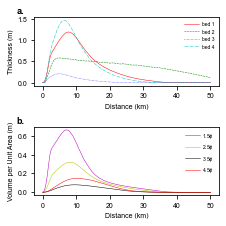

In [105]:
# Calculate longitudinal variation of mean grain size
mean_grain_size = np.zeros([num_data, num_grids])
significant_thick = np.where(thickness > 0.01)
for i in range(gclass_num):
    mean_grain_size[significant_thick] += gclass_value[i] * volume_unit_area[i][significant_thick]
mean_grain_size[significant_thick] /= thickness[significant_thick]

# Calculate mean and standard deviation of thickness and maximum reach of beds
mean_max_thick = np.average(np.max(thickness, axis=1))
std_max_thick = np.std(np.max(thickness, axis=1), ddof=1)
x = np.tile(np.arange(0, num_grids * dx, dx), num_data).reshape(num_data, num_grids)
x[thickness < 0.01] = 0
mean_max_reach = np.average(np.max(x, axis=1))
std_max_reach = np.std(np.max(x, axis=1), ddof=1)

print('Mean of maximum thickness of beds: {} m'.format(mean_max_thick))
print('Standard deviation of maximum thickness of beds: {} m'.format(std_max_thick))
print('Mean of maximum reach of bed (> 1cm): {}'.format(mean_max_reach))
print('Standard deviation of maximum reach of bed (> 1cm): {}'.format(std_max_reach))

# plot data sets
xrange=np.array([0, 50000])
xrange_grid = (xrange / dx).astype(np.int32)
x = np.arange(xrange[0], xrange[1], dx)
start_id = 6
num_beds = 4

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 3,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
         }
plt.rcParams.update(params)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(8/2.54,8/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.4)
for i in range(start_id, start_id + num_beds):
    ax[0].plot(x / 1000, thickness[i,xrange_grid[0]:xrange_grid[1]],
               lw=linewidth, linestyle=linestyle[(i - start_id)%4],
               color=linecolor[lc_id%7], label='bed {}'.format(i - start_id + 1))
    lc_id += 1
ax[0].set_xlabel('Distance (km)', fontsize=7)
ax[0].set_ylabel('Thickness (m)', fontsize=7)
ax[0].legend()
ylim = ax[0].get_ylim()
xlim = ax[0].get_xlim()
ax[0].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'a.', fontweight='bold', fontsize=9)

# for k in range(start_id, start_id + num_beds):
#     ax[0,1].plot(x, mean_grain_size[k, xrange_grid[0]:xrange_grid[1]],label='bed{}'.format(k))
# ax[0,1].legend()
# ax[0,1].set_ylim([1.5, 4.5])

# for j in range(gclass_num):
for j in range(gclass_num):
    ax[1].plot(x / 1000, volume_unit_area[j, start_id, xrange_grid[0]:xrange_grid[1]],
               lw=linewidth, color=linecolor[lc_id%7], label=gclass_name[j])
    lc_id += 1
ax[1].set_xlabel('Distance (km)', fontsize=7)
ax[1].set_ylabel('Volume per Unit Area (m)', fontsize=7)
# ax[1].set_xlim(0,)
# ax[1].set_ylim(0,)
ax[1].legend()
ylim = ax[1].get_ylim()
xlim = ax[1].get_xlim()
ax[1].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'b.', fontweight='bold', fontsize=9)

# for j in range(gclass_num):
#     ax[1,1].plot(x, volume_unit_area[j, start_id + 1, xrange_grid[0]:xrange_grid[1]],label=gclass_name[j])
# ax[1,1].legend()
#plt.tight_layout()
plt.tight_layout()
plt.savefig('tex/fig04.eps')
plt.show()

# Show training results depending on number of training data sets and length of sampling window

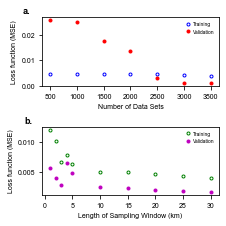

In [108]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance'
resdir_train_num = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10'
resdir_distance = '/home/naruse/public/naruse/DeepLearningTurbidite/result_distance_3500'
base_distance = 10
base_train_num = 3500
case_train_num = [500, 1000, 1500, 2000, 2500, 3000, 3500]
case_distance = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(8/2.54,8/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5)

# Plot results depending on number of training data sets
loss_train_num = []
val_loss_train_num = []
for train_num in case_train_num:
    loss_train_num.append(
        np.loadtxt(join(resdir_train_num, '{}'.format(train_num),
                        'loss.txt'), delimiter=',')[-1])
    val_loss_train_num.append(
        np.loadtxt(join(resdir_train_num, '{}'.format(train_num),
                        'val_loss.txt'), delimiter=',')[-1])
ax[0].plot(case_train_num, loss_train_num, 'bo', markerfacecolor='w',
                label='Training', markersize=3)
ax[0].plot(case_train_num, val_loss_train_num, 'ro', markerfacecolor='r',
                label='Validation', markersize=3)
ax[0].set_xlabel('Number of Data Sets', fontsize=7)
ax[0].set_ylabel('Loss function (MSE)', fontsize=7)
ax[0].legend()
ylim = ax[0].get_ylim()
xlim = ax[0].get_xlim()
ax[0].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'a.', fontweight='bold', fontsize=9)

# Plot results depending on lengths of sampling window
loss_distance = []
val_loss_distance = []
for distance in case_distance:
    loss_distance.append(
        np.loadtxt(join(resdir_distance, '{}'.format(distance),
                        'loss.txt'), delimiter=',')[-1])
    val_loss_distance.append(
        np.loadtxt(join(resdir_distance, '{}'.format(distance),
                        'val_loss.txt'), delimiter=',')[-1])
ax[1].plot(case_distance, loss_distance, 'go', markerfacecolor='w',
                label='Training', markersize=3)
ax[1].plot(case_distance, val_loss_distance, 'mo', markerfacecolor='m',
                label='Validation', markersize=3)
ax[1].set_xlabel('Length of Sampling Window (km)', fontsize=7)
ax[1].set_ylabel('Loss function (MSE)', fontsize=7)
ax[1].legend()
ylim = ax[1].get_ylim()
xlim = ax[1].get_xlim()
ax[1].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'b.', fontweight='bold', fontsize=9)

# Save figures
plt.tight_layout()
plt.savefig('tex/fig05.eps')



# Show test results

\begin{tabular}{lrrrrrrr}
\toprule
{} &  R\textasciicircum 2 &  RMSE &  RMSE (normalized) &   MAE &  MAE (normalized) &  Mean bias &  Mean bias (normalized) \\
\midrule
Initial height & 0.99 & 18.97 &               8.55 & 14.81 &              5.96 &     -12.93 &                   -5.18 \\
Initial length & 0.99 & 15.82 &               7.53 & 12.09 &              4.92 &      -2.33 &                   -2.06 \\
C\_1            & 0.99 &  0.02 &              12.91 &  0.02 &              6.00 &      -0.01 &                   -4.44 \\
C\_2            & 0.99 &  0.02 &              15.57 &  0.02 &              7.67 &      -0.01 &                   -4.29 \\
C\_3            & 0.99 &  0.02 &              13.03 &  0.02 &              6.39 &      -0.00 &                   -2.49 \\
C\_4            & 0.99 &  0.03 &              13.71 &  0.02 &              6.67 &      -0.01 &                   -4.21 \\
S\_l            & 0.98 &  0.03 &              19.56 &  0.03 &             11.67 &       0.03 &       

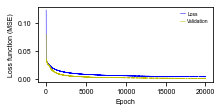

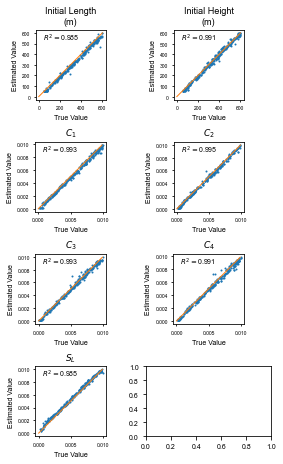

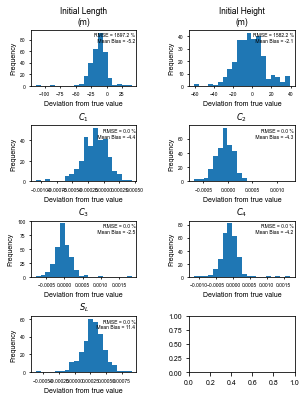

In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.utils import resample
import pandas as pd
%matplotlib inline

# datadir = '/home/naruse/antidune/Documents/PythonScripts/DeepLearningTurbidite/20180419/data/'
# resdir = '/home/naruse/antidune/Documents/PythonScripts/DeepLearningTurbidite/20180419/result_testGPU_4layers/2670/'
datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance/10/data/'
resdir = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10/3500/'

test_result = np.loadtxt(os.path.join(resdir, 'test_result.txt'),delimiter=',')
icond = np.load(os.path.join(datadir, 'icond_test.npy'))
loss = np.loadtxt(os.path.join(resdir, 'loss.txt'), delimiter=',')
vloss = np.loadtxt(os.path.join(resdir, 'val_loss.txt'), delimiter=',')
epoch = range(0,loss.shape[0])

# Calculate statistics
resi_ratio = (test_result - icond) / icond
resi = test_result - icond
r2value = []
for i in range(icond.shape[1]):
    r2value.append(r2_score(icond[:, i], test_result[:, i]))

mean_bias = np.average(resi,axis=0)
std_bias = np.std(resi,axis=0, ddof=1)
rmse = np.sqrt(np.sum(resi ** 2, axis=0) / resi.shape[0])
mae = np.sum(np.abs(resi), axis=0) / resi.shape[0]

mean_bias_ratio = np.average(resi_ratio,axis=0)
std_bias_ratio = np.std(resi_ratio,axis=0, ddof=1)
rmse_ratio = np.sqrt(np.sum(resi_ratio ** 2, axis=0) / resi_ratio.shape[0])
mae_ratio = np.sum(np.abs(resi_ratio), axis=0) / resi.shape[0]

# make a table for exhibiting statistics
df_stats = pd.DataFrame(
    {
        "R^2" : r2value,
        "RMSE" : rmse,
        "RMSE (normalized)" : rmse_ratio * 100,
        "MAE" : mae,
        "MAE (normalized)" : mae_ratio * 100,
        "Mean bias" : mean_bias,
        "Mean bias (normalized)" : mean_bias_ratio * 100,
    },
    index = [
        'Initial height',
        'Initial length',
        'C_1',
        'C_2',
        'C_3',
        'C_4',
        'S_l']
)
df_stats.loc['C_1':'S_l' ,['RMSE', 'MAE', 'Mean bias']] *= 100
print(df_stats.to_latex(float_format='%.2f'))


# Boostrap resampling
# n = 10000
# resampled_resi = np.empty(resi.shape)
# resampled_mean = np.zeros([n, resi.shape[1]])
# for i in range(resi.shape[1]):
#     for j in range(n):
#         resampled_resi[:,i] = resample(resi_ratio[:,i])
#         resampled_mean[j, i] = np.average(resampled_resi[:,i])

# Bootstrap mean and error range
# mean_bias_bootstrap = np.average(resampled_mean, axis=0)
# lowerbounds_bias_bootstrap = np.percentile(resampled_mean, 2.5, axis=0)
# upperbounds_bias_bootstrap = np.percentile(resampled_mean, 97.5, axis=0)

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)

# plot training history
fig, ax = plt.subplots(1,1, figsize=(8/2.54,4/2.54))
ax.plot(epoch, loss, 'b-',label='Loss', lw=0.5)
ax.plot(epoch, vloss, 'y-',label='Validation', lw=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss function (MSE)')
ax.legend(loc="upper right")
plt.savefig('tex/fig06.eps')

print('Training loss: {}'.format(loss[-1]))
print('Validation loss: {}'.format(vloss[-1]))

hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Initial Length\n(m)', 'Initial Height\n(m)', '$C_1$', '$C_2$', '$C_3$', '$C_4$', '$S_L$']

# Scattered plots to compare the predicted values with the true values
fig2, ax2 = plt.subplots(int(len(titlelabel)/2) + 1, 2, figsize=(12/2.54, 19/2.54))
plt.subplots_adjust(wspace=0.1, hspace=0.6)
for i in range(len(titlelabel)):
    x_fig = int(i/2)
    y_fig = i%2          
    ax2[x_fig, y_fig].plot(icond[:,i],test_result[:,i],"o", markersize=1)
    ax2[x_fig, y_fig].plot([0,np.max(test_result[:,i])], [0, np.max(test_result[:,i])],
                           "-", lw=linewidth*2)
    ax2[x_fig, y_fig].set_xlabel('True Value',color=textcol,fontsize=7)
    ax2[x_fig, y_fig].set_ylabel('Estimated Value',color=textcol,fontsize=7)
    ax2[x_fig, y_fig].set_title(titlelabel[i],color=textcol,fontsize=9)
    ax2[x_fig, y_fig].tick_params(colors=textcol,length=2,labelsize=5)
    ax2[x_fig, y_fig].set_aspect('equal')
    xlim = ax2[x_fig, y_fig].get_xlim()
    ylim = ax2[x_fig, y_fig].get_ylim()
    xloc = xlim[0] + (xlim[1] - xlim[0]) * 0.1
    yloc = ylim[0] + (ylim[1] - ylim[0]) * 0.85
    ax2[x_fig, y_fig].text(xloc, yloc, '$R^2 = ${:.3f}'.format(r2value[i]))
# fig.tight_layout()
plt.savefig('tex/fig07.eps')
    #plt.show()

# Histograms for prediction errors
fig3, ax3 = plt.subplots(int(len(titlelabel)/2) + 1, 2, figsize=(12/2.54, 16/2.54))
plt.subplots_adjust(wspace=0.5, hspace=0.7)
for i in range(len(titlelabel)):
    x_fig = int(i/2)
    y_fig = i%2
    ax3[x_fig, y_fig].hist(resi[:,i],bins=20)
    ax3[x_fig, y_fig].set_title(titlelabel[i],color=textcol)
    ax3[x_fig, y_fig].set_xlabel('Deviation from true value',color=textcol, fontsize=7)
    ax3[x_fig, y_fig].set_ylabel('Frequency',color=textcol, fontsize=7)
    ax3[x_fig, y_fig].tick_params(colors=textcol, length=2, labelsize=5)
    # xlim = ax3[x_fig, y_fig].get_xlim()
    # ylim = ax3[x_fig, y_fig].get_ylim()
    # xloc = xlim[0] + (xlim[1] - xlim[0]) * 0.1
    # yloc = ylim[0] + (ylim[1] - ylim[0]) * 0.7
    ax3[x_fig, y_fig].text(0.99, 0.95,
                'RMSE = {0:.1f} %\n Mean Bias = {1:.1f}'.format(
                    rmse[i] * 100, mean_bias_ratio[i] * 100),
                    # lowerbounds_bias_bootstrap[i] * 100,
                    # upperbounds_bias_bootstrap[i] * 100),
                           horizontalalignment='right', verticalalignment='top',
                           transform=ax3[x_fig, y_fig].transAxes, fontsize=5)

fig.tight_layout()
plt.savefig('tex/fig08.eps')
    #plt.show()


# Check bias and errors of predicted values

mean bias
[-1.29266316e+01 -2.32764039e+00 -1.42043143e-04 -5.58904978e-05
 -3.05209377e-05 -9.54839696e-05  2.89349487e-04]
2σ of bias
[2.78196676e+01 3.13524848e+01 4.04460461e-04 4.01557574e-04
 4.80633580e-04 5.31698802e-04 3.78284572e-04]
RMSE
9.33717357851972
mean bias (ratio)
[-0.05178297 -0.02058269 -0.04440971 -0.0429332  -0.02491598 -0.04206466
  0.11448568]
2σ of bias (ratio)
[0.13624629 0.14501837 0.24293689 0.29978833 0.2562501  0.26138126
 0.31784317]
RMSE (ratio)
0.13519205042019936
p-values of the Shapiro-Wilk test for normality
7.849864286152072e-15
0.00040593656012788415
8.476071343466174e-06
2.2713582126243637e-09
5.597754790080678e-14
1.5576918959347638e-14
3.69856643374078e-05
mean bias (bootstrap samples)
[-0.05177063 -0.02051589 -0.04449836 -0.04274484 -0.02480929 -0.04208389
  0.11432631]
2.5 percentile of biases (bootstrap samples)
[-0.05933748 -0.02881048 -0.05900583 -0.06028632 -0.03990595 -0.05753963
  0.09736634]
97.5 percentile of biases (bootstrap samples

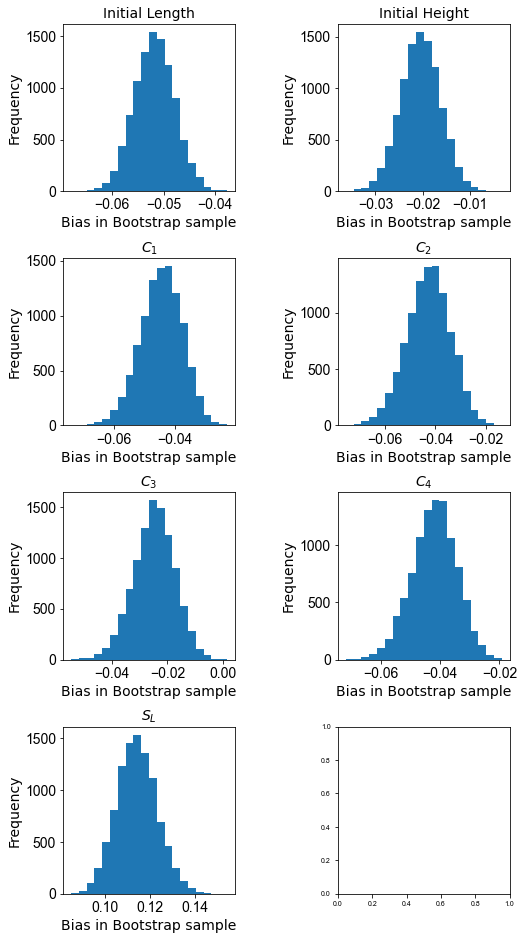

In [126]:
from scipy import stats
import numpy as np
from sklearn.utils import resample
import ipdb

resi_ratio = (test_result - icond) / icond
resi = test_result - icond

print("mean bias")
print(np.average(resi,axis=0))
print("2σ of bias")
print(np.std(resi,axis=0, ddof=1)*2)
print("RMSE")
print(np.sqrt(np.sum(resi**2)/resi.shape[0]/resi.shape[1]))

print("mean bias (ratio)")
print(np.average(resi_ratio,axis=0))
print("2σ of bias (ratio)")
print(np.std(resi_ratio,axis=0, ddof=1)*2)
print("RMSE (ratio)")
print(np.sqrt(np.sum(resi_ratio**2)/resi_ratio.shape[0]/resi_ratio.shape[1]))

print("p-values of the Shapiro-Wilk test for normality")
for i in range(resi.shape[1]):
    print(stats.shapiro(resi[:,i])[1])


# Bootstrap mean and error range
print("mean bias (bootstrap samples)")
print(np.average(resampled_mean, axis=0))
print("2.5 percentile of biases (bootstrap samples)")
print(np.percentile(resampled_mean, 2.5, axis=0))
print("97.5 percentile of biases (bootstrap samples)")
print(np.percentile(resampled_mean, 97.5, axis=0))

# Histograms of bootstrap samples
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Initial Length', 'Initial Height', '$C_1$', '$C_2$', '$C_3$', '$C_4$', '$S_L$']
fig4, ax4 = plt.subplots(int(len(titlelabel)/2) + 1, 2, figsize=(8, 4 * np.ceil(len(titlelabel) / 2)))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
for i in range(len(titlelabel)):
    ax4[int(i/2), i%2].hist(resampled_mean[:,i],bins=20)
    ax4[int(i/2), i%2].set_title(titlelabel[i],color=textcol,size=14,**hfont)
    ax4[int(i/2), i%2].set_xlabel('Bias in Bootstrap sample',color=textcol,size=14,**hfont)
    ax4[int(i/2), i%2].set_ylabel('Frequency',color=textcol,size=14,**hfont)
    ax4[int(i/2), i%2].tick_params(labelsize=14,colors=textcol)
fig.tight_layout()
plt.savefig('hist_bootstrap.pdf')



# Compare time evolution of reconstructed parameters with original ones

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from os import mkdir
from scipy.interpolate import interp1d
import pandas as pd
%matplotlib

original_dir = '/home/naruse/antidune/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_original5'
estimated_dir = '/home/naruse/antidune/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_reconst5'
dist_offset = 5000.
dist_max = 30000.
topodx = 5
grid_origin = int(dist_offset / topodx)
grid_end = int((dist_max + dist_offset)/topodx)
snapshot_time = np.array([2000, 3500, 5000])
time_interval = 200.
time_frame = (snapshot_time / time_interval).astype(np.int64)

icond_estimated = np.loadtxt(join(estimated_dir, 'icond.txt'),delimiter=',')
Ht_estimated = np.loadtxt(join(estimated_dir, 'Ht.txt'),delimiter=',')
Ct_estimated = np.loadtxt(join(estimated_dir, 'Ct.txt'),delimiter=',')
U_estimated = np.loadtxt(join(estimated_dir, 'U.txt'),delimiter=',')
x_estimated = np.loadtxt(join(estimated_dir, 'x.txt'),delimiter=',')
x_bed = np.loadtxt(join(estimated_dir, 'x_init.txt'),delimiter=',')
time_estimated = np.loadtxt(join(estimated_dir, 'time.txt'),delimiter=',') 

icond_original = np.loadtxt(join(original_dir, 'icond.txt'),delimiter=',')
Ht_original = np.loadtxt(join(original_dir, 'Ht.txt'),delimiter=',')
Ct_original = np.loadtxt(join(original_dir, 'Ct.txt'),delimiter=',')
U_original = np.loadtxt(join(original_dir, 'U.txt'),delimiter=',')
x_original = np.loadtxt(join(original_dir, 'x.txt'),delimiter=',')
time_original = np.loadtxt(join(original_dir, 'time.txt'),delimiter=',')


print('Reconstructed values: {}'.format(icond_estimated))
print('True values: {}'.format(icond_original))
print('RMSE: {}'.format(np.sqrt(np.sum(((icond_estimated - icond_original)/icond_original)**2)/icond_estimated.shape[0])))

# Make a table to exhibit true and predicted values of model input parameters
df = pd.DataFrame(np.array([[icond_original[:]], [icond_estimated[:]]]).reshape(2, 7),
                  columns=[
                      'Initial height (m)',
                      'Initial length (m)',
                      'C_1 (%)',
                      'C_2 (%)',
                      'C_3 (%)',
                      'C_4 (%)',
                      'S_l (%)'
                  ],
                 index=[
                     'True input parameters',
                     'Estimated parameters'
                 ])
df.loc[:, 'C_1 (%)':'S_l (%)'] *= 100
print(df.to_latex(float_format='%.2f'))


# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)

# Plot results
fig1, ax1 = plt.subplots(3, 1, figsize=(8/2.54, 12/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5)

# plot flow velocity
for tframe, col in zip(time_frame, linecolor):
    ax1[0].plot(x_estimated[tframe,:]/1000, U_estimated[tframe,:],
             '-', color=col, lw=linewidth, label='{} sec.'.format(tframe*time_interval))
    ax1[0].plot(x_original[tframe,:]/1000, U_original[tframe,:],'--',
             color=col, lw=linewidth, label=None)
# ax1[0].set_title('Flow Velocity', fontsize=9)
ax1[0].set_xlabel('Distance (km)', fontsize = 7)
ax1[0].set_ylabel('Velocity (m/s)', fontsize = 7)
ax1[0].legend()
xlim = ax1[0].get_xlim()
ylim = ax1[0].get_ylim()
ax1[0].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'a.', fontweight='bold', fontsize=9)

# plot sediment concentration
for tframe, col in zip(time_frame, linecolor):
    ax1[1].plot(x_estimated[tframe,:]/1000, Ct_estimated[tframe,:] * 100, '-',
             color=col, lw=linewidth, label='{} sec.'.format(tframe*time_interval))
    ax1[1].plot(x_original[tframe,:]/1000, Ct_original[tframe,:] * 100, '--',
             color=col, lw=linewidth, label=None)
# ax1[1].set_title('Total Concentration', fontsize = 9)
ax1[1].set_xlabel('Distance (km)', fontsize = 7)
ax1[1].set_ylabel('Concentration (%)', fontsize = 7)
ax1[1].legend()
xlim = ax1[1].get_xlim()
ylim = ax1[1].get_ylim()
ax1[1].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'b.', fontweight='bold', fontsize=9)

# plot thickness 
ax1[2].plot(x_bed[grid_origin:grid_end]/1000, Ht_estimated[-1,grid_origin:grid_end],'k--',
         lw=linewidth, label='Estimated')
ax1[2].plot(x_bed[grid_origin:grid_end]/1000, Ht_original[-1,grid_origin:grid_end],'k-',
         lw=linewidth, label='Original')
# ax1[2].set_title('Bed thickness', size = 9, **hfont)
ax1[2].set_xlabel('Distance (km)', fontsize = 7)
ax1[2].set_ylabel('Thickness (m)', fontsize = 7)
xlim = ax1[2].get_xlim()
ylim = ax1[2].get_ylim()
ax1[2].legend()
ax1[2].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'c.', fontweight='bold', fontsize=9)

# save figure
plt.tight_layout()
plt.savefig('tex/fig09.eps')

# Time evolution at fixed location
start = 0.0
endtime = 5000.0
start_d = int(start / time_interval)
endtime_d = int(endtime / time_interval)

outcrop = np.array([5*1000, 8 * 1000, 10 * 1000])
linecolor = ['r', 'g', 'b']

U_original_loc = np.zeros([len(time_original),len(outcrop)])
U_estimated_loc = np.zeros([len(time_original),len(outcrop)])
if len(time_original) > len(time_estimated):
    time_length = len(time_estimated)
else:
    time_length = len(time_original)

for j in range(time_length):
    f_original = interp1d(x_original[j,:], U_original[j,:], kind="linear", bounds_error=False, fill_value=0)
    U_original_loc[j,:] = f_original(outcrop)
    f_estimated = interp1d(x_estimated[j,:], U_estimated[j,:], kind="linear", bounds_error=False, fill_value=0)
    U_estimated_loc[j,:] = f_estimated(outcrop)

#図にプロットする
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
for k in range(len(outcrop)):
    ax2.plot(time_original[start_d:endtime_d], U_original_loc[start_d:endtime_d,k], '--',
             color= linecolor[k], label=None)
    ax2.plot(time_estimated[start_d:endtime_d], U_estimated_loc[start_d:endtime_d,k], '-',
             color= linecolor[k], label='{} km'.format(outcrop[k] / 1000))
ax2.legend()
ax2.set_xlabel('Time (s.)')
ax2.set_ylabel('Velocity (m/s)')
# ax2.set_title('Velocity')
plt.savefig('compare_result_fixedloc.svg')




Using matplotlib backend: agg
Reconstructed values: [4.5467e+02 3.0173e+02 1.7977e-03 1.5926e-04 9.2914e-03 7.2649e-03
 2.5254e-03]
True values: [4.8441e+02 3.1818e+02 1.6565e-03 5.4632e-04 9.5318e-03 7.4443e-03
 2.2881e-03]
RMSE: 0.27454715314370537
\begin{tabular}{lrrrrrrr}
\toprule
{} &  Initial height (m) &  Initial length (m) &  C\_1 (\%) &  C\_2 (\%) &  C\_3 (\%) &  C\_4 (\%) &  S\_l (\%) \\
\midrule
True input parameters &              484.41 &              318.18 &     0.17 &     0.05 &     0.95 &     0.74 &     0.23 \\
Estimated parameters  &              454.67 &              301.73 &     0.18 &     0.02 &     0.93 &     0.73 &     0.25 \\
\bottomrule
\end{tabular}



# tests with normal random numbers

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.stats import sem
import os
%matplotlib inline

def check_noise(model=None,
                X_test=None,
                y_test=None,
                y_min=None,
                y_max=None,
                min_x=None,
                max_x=None,
                err_rate=0.10,
                datadir = None,
                resdir = None,
                gclass = 4,
                topodx = 5,
                plot_fig = True,
                ):
    
    # Obtain the original data sets
    if X_test is None: X_test = np.load(os.path.join(datadir, 'H_test.npy'))
    if y_test is None: y_test = np.load(os.path.join(datadir, 'icond_test.npy'))
    if y_min is None: y_min = np.load(os.path.join(datadir, 'icond_min.npy'))
    if y_max is None: y_max = np.load(os.path.join(datadir, 'icond_max.npy'))

    
    # normalization
    if min_x is None or max_x is None: min_x, max_x = np.load(os.path.join(datadir, 'x_minmax.npy'))
    X_test_norm =  (X_test - min_x) / (max_x - min_x)

    # add noise
    # 2 sigma = true parameter times err_rate
    err = np.random.normal(size=X_test_norm.shape)
    x_test_norm_w_error = X_test_norm + err * 0.5 * err_rate * X_test_norm
    num_node_per_gclass = int(X_test_norm.shape[1] / gclass)
    dist = np.arange(0,num_node_per_gclass)* topodx
    

    #print(X_test_norm[1,1000:1010])
    #print(x_test_norm_w_error[1,1000:1010])
    #print(err[1,1000:1010])

    # load the model if the model is None
    # model = load_model(resdir+'model.hdf5')
    test_result = model.predict(X_test_norm)
    test_result = test_result * (y_max - y_min) + y_min
    test_result_w_error = model.predict(x_test_norm_w_error)
    test_result_w_error = test_result_w_error * (y_max - y_min) + y_min

    # Load true parameters
    icond = np.load(os.path.join(datadir, 'icond_test.npy'))
    loss = np.loadtxt(os.path.join(resdir, 'loss.txt'), delimiter=',')
    epoch = range(0,len(loss))
    vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
    
    # Calculate residuals
    resi = (test_result - icond)
    resi_w_error = (test_result_w_error - icond)
    resi_w_error_ratio = (test_result_w_error - icond) / icond

    # Plot figure of each test
    if plot_fig:
        plt.figure()
        plt.plot(x_test_norm_w_error[1,0:num_node_per_gclass], label='With Error')
        plt.plot(X_test_norm[1,0:num_node_per_gclass], label='Original')
        plt.xlabel('Distance')
        plt.ylabel('Normalized thickness')
        plt.legend()

    
        titlelabel = ['Initial Length', 'Initial Height', '$C_1$', '$C_2$', '$C_3$', '$C_4$', '$S_1$']
        hfont = {'fontname':'Century Gothic'}
        textcol = 'k'
    
        for i in range(len(titlelabel)):
            plt.figure()
            plt.plot(icond[:,i],test_result[:,i],"bo",label='without error')
            plt.plot(icond[:,i],test_result_w_error[:,i],"ro",label='with error ({:.0f}%)'.format(err_rate*100))
            plt.title(titlelabel[i],color=textcol,size=14,**hfont)
            plt.xlabel('True values',color=textcol,size=14,**hfont)
            plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
            plt.legend()
            plt.tick_params(labelsize=14,colors=textcol)
            plt.savefig(titlelabel[i] + 'err{:.0f}'.format(err_rate*100) + '.pdf')
            #plt.show()

        for i in range(len(titlelabel)):
            plt.figure()
            plt.hist(resi_w_error[:,i],bins=20)
            plt.title(titlelabel[i])
            plt.xlabel('Deviation from true value')
            plt.ylabel('Frequency')
            #plt.show()

#        print("Mean Square error")
#        print(np.average(resi**2,axis=0))
#        print("MSE with noise")
#        print(np.average(resi_w_error**2,axis=0))
#        print("Mean error")
#        print(np.average(resi,axis=0))
#        print("Mean error with noise)
#        print(np.average(resi_w_error,axis=0))
#        print("2 sigma of residuals")
#        print(np.std(resi,axis=0)*2)
#        print("2 sigma of residuals with noise")
#        print(np.std(resi_w_error,axis=0)*2)
#        print("ratio of residuals to true value")
#        print(np.average(np.abs(resi)/icond,axis=0))
#        print("ratio of residuals to true value with noise")
#        print(np.average(np.abs(resi_w_error)/icond,axis=0))
#        print("p-values of the Shapiro-Wilk test for normality")
#        for i in range(resi.shape[1]):
 #           print(stats.shapiro(resi[:,i])[1])
 #           print("p-values of the Shapiro-Wilk test for normality (with error)")
 #       for i in range(resi_w_error.shape[1]):
 #           print(stats.shapiro(resi_w_error[:,i])[1])
    
    # Return normalized RMSE
    RMS = np.sqrt(np.sum(resi_w_error_ratio ** 2) / resi_w_error_ratio.shape[0] / resi_w_error_ratio.shape[1])
    
    return RMS
    
if __name__ == "__main__":
    datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance/10/data/'
    resdir = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10/3500/'
    model = load_model(os.path.join(resdir, 'model.hdf5'))
    
    noisetest_err_rate = np.linspace(0,2.0,40)
    result_noise = np.zeros(len(noisetest_err_rate))
    result_noise_stderr = np.zeros(len(noisetest_err_rate))
    num_tests = 20
    for i in range(len(noisetest_err_rate)):
        testres = np.zeros([num_tests])
        for j in range(num_tests):
            testres[j] = check_noise(model, datadir=datadir, resdir=resdir, err_rate=noisetest_err_rate[i], plot_fig=False)
        result_noise[i] = np.average(testres)
        result_noise_stderr[i] = sem(testres)
        
    np.savetxt("result_w_error.csv",result_noise,delimiter=',')
    
   

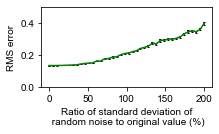

In [60]:
%matplotlib inline

# plot result of noise tests

fig1, ax1 = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5, hspace=0.3)

ax1.errorbar(noisetest_err_rate*100, result_noise, color='g', yerr=result_noise_stderr, ecolor='k', capsize=1.)
# ax1.title("$S_L$")
ax1.set_xlabel('Ratio of standard deviation of\n random noise to original value (%)')
ax1.set_ylabel('RMS error')
ax1.set_ylim([0,0.5])
# ax1.legend()
# plt.tick_params(labelsize=14,colors=textcol)
plt.tight_layout()
plt.savefig("tex/fig10.eps")
        
        

# Subsampling tests

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
from scipy.stats import sem
from os.path import join
%matplotlib inline

def check_interp(model=None,
                 X_test=None,
                 y_test=None,
                 y_min=None,
                 y_max=None,
                 frac = 0.005,
                datadir = None,
                resdir = None,
                 plot_fig = True,
                ):

    # Obtain the original data sets
    if X_test is None: X_test = np.load(join(datadir, 'H_test.npy'))
    if y_test is None: y_test = np.load(join(datadir, 'icond_test.npy'))
    if y_min is None: y_min = np.load(join(datadir, 'icond_min.npy'))
    if y_max is None: y_max = np.load(join(datadir, 'icond_max.npy'))

    
    # normalization
    min_x, max_x = np.load(join(datadir, 'x_minmax.npy'))
    X_test_norm =  (X_test - min_x) / (max_x - min_x)

    # Subsampling
    #frac = 0.005 # ratio of subsampling
    gclass = 4 # number of grain size classes
    coord_num = X_test_norm.shape[1] / gclass # number of grids
    sam_coord_num = np.round(frac * coord_num) # number of subsampled grids
    x_coord = np.arange(X_test_norm.shape[1]/ gclass) # Index number of grids
    sampleid = np.sort(np.random.choice(x_coord,int(sam_coord_num),replace=False)) # subsampled id of grids

    thick_interp = np.zeros(X_test.shape) # interpolated thickness data
    for j in range(gclass):
        sid = sampleid + coord_num * j
        #print(sid)
        sindex = sid.astype(np.int32)
        f = interp1d(sid,X_test_norm[:,sindex], kind="linear", fill_value='extrapolate') # interpolation funciton for the jth grain size class
        coord_range = np.arange(coord_num*j, coord_num*(j+1)) # range to interpolate
        thick_interp[:,coord_range.astype(np.int32)] = f(coord_range) # interpolated data


    # Load the model and predict from subsampled data
    if model is None: model = load_model(join(resdir, 'model.hdf5'))
    test_result = model.predict(X_test_norm)
    test_result = test_result * (y_max - y_min) + y_min
    test_result_sample = model.predict(thick_interp)
    test_result_sample = test_result_sample * (y_max - y_min) + y_min

    # calculate residuals
    icond = np.load(join(datadir, 'icond_test.npy'))
    resi = test_result - icond
    resi_sample = test_result_sample - icond
    resi_sample_ratio = (test_result_sample - icond) / icond

    # comparison with original reconstruction
    titlelabel = ['Initial Length', 'Initial Height', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$S_1$']
    hfont = {'fontname':'Century Gothic'}
    textcol = 'w'
    
    if plot_fig:
        for i in range(len(titlelabel)):
            plt.figure()
            plt.plot(icond[:,i],test_result[:,i],"bo",label='Original')
            plt.plot(icond[:,i],test_result_sample[:,i],"ro",label='Resampled data ({:.1f}%)'.format(frac*100))
            plt.title(titlelabel[i],color=textcol,size=14,**hfont)
            plt.xlabel('True values',color=textcol,size=14,**hfont)
            plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
            plt.legend()
            plt.tick_params(labelsize=14,colors=textcol)
            plt.savefig(titlelabel[i] + 'resample{:.1f})'.format(frac*100) + '.pdf')
            plt.show()

        for i in range(len(titlelabel)):
            plt.figure()
            plt.hist(resi_sample[:,i],bins=20)
            plt.title(titlelabel[i])
            plt.xlabel('Deviation from true value')
            plt.ylabel('Frequency')
            plt.show()

        print("mean residuals")
        print(np.average(resi,axis=0))
        print("mean residuals (subsampled)")
        print(np.average(resi_sample,axis=0))
        print("2 sigma of residuals")
        print(np.std(resi,axis=0)*2)
        print("2 sigma of residuals (subsampled)")
        print(np.std(resi_sample,axis=0)*2)
        print()
        print("p-values of the Shapiro-Wilk test for normality")
        for i in range(resi.shape[1]):
            print(stats.shapiro(resi[:,i])[1])
        print("p-values of the Shapiro-Wilk test for normality (with error)")
        for i in range(resi_sample.shape[1]):
            print(stats.shapiro(resi_sample[:,i])[1])
            
    # Return normalized RMSE
    RMS = np.sqrt(np.sum(resi_sample_ratio ** 2) / resi_sample_ratio.shape[0] / resi_sample_ratio.shape[1])
    
    return RMS

if __name__ == "__main__":
    datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance/10/data/'
    resdir = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10/3500/'
    subsampling_result_file = join(resdir, 'subsampling_result.npy')
    subsampling_result_error_file = join(resdir, 'subsampling_result_error.npy')
    model = load_model(join(resdir, 'model.hdf5'))
    
    subsampling_test_err_rate = np.linspace(0.05,0.001,50)
    result_subsampling = np.zeros([len(subsampling_test_err_rate)])
    result_subsampling_error = np.zeros([len(subsampling_test_err_rate)])
    num_tests = 20
    for i in range(len(subsampling_test_err_rate)):
        testres = np.zeros([num_tests])
        for j in range(num_tests):
            testres[j] = check_interp(model, datadir=datadir, resdir=resdir, frac=subsampling_test_err_rate[i], plot_fig=False)
        result_subsampling[i] = np.average(testres)
        result_subsampling_error[i] = sem(testres)
    
    np.save(subsampling_result_file, result_subsampling)
    np.save(subsampling_result_error_file, result_subsampling_error)

    
    
    

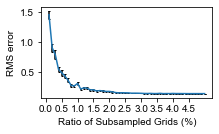

In [27]:
%matplotlib inline

fig1, ax1 = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5, hspace=0.3)


plt.errorbar(subsampling_test_err_rate*100, result_subsampling, yerr=result_subsampling_error, ecolor='k', capsize=1.)
ax1.set_xlabel('Ratio of Subsampled Grids (%)') 
ax1.set_ylabel('RMS error')
ax1.set_xticks(np.arange(0, 5, 0.5))
# ax1.legend()
# plt.tick_params(labelsize=14,colors=textcol)
plt.tight_layout()
plt.savefig("tex/fig11.eps")
